# AGBench 🌴🛰

We introduce the package AGBench: an end-to-end method to benchmark an aboveground biomass (AGB) or carbon estimation map with real field data.

### Datasets
For this Jupyter notebook we use the following datasets:
- Reforestation Field Data 
    - 6 sites of ~0.5ha each of tropical agroforestry of banana and cacao in Ecuador
    - each tree has manually been measured (species&DBH) to determine AGB and carbon
    - drone imagery of each site
 
- [Global Forest Watch's Aboveground Woodly Biomass](https://data.globalforestwatch.org/datasets/gfw::aboveground-live-woody-biomass-density/about)
    - a global map of AGB and carbon density at a 30x30m resolution
- Spawn et al (2020): [Global Aboveground and Belowground Biomass Carbon Density Maps for the Year 2010](https://doi.org/10.3334/ORNLDAAC/1763)
    - a global map of AGB and carbon density at a 300x300m resolution
- Santoro et al. (2018): [GlobBiomass - Global Datasets of Forest Biomass](https://doi.org/10.1594/PANGAEA.894711)
    - a global map of AGB and carbon density at a 100x100m resolution

    
----   
#### 👉🏼 Remark: 
This code is currently only suited for AGB density (tons/ha) benchmarks. With small improvements of the code it can also be used to benchmark total AGB (tons), total carbon (tons), or carbon density (tons/ha)

## Load packages and modules

In [ ]:
!pip install -Ur ../requirements.txt

In [1]:
import os
import sys
package = os.path.dirname(os.getcwd())
sys.path.append(package)
sys.path.append(package + '/utils')

import matplotlib.pylab as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from PIL import Image
import cv2

In [2]:
from processing import *
from visualization import *

## Load field data

In [3]:
path_to_AGBench = ".."

In [4]:
# Load field data of AGB and carbon of the sites
field_data = pd.read_csv('{}/data/field_data/benchmark_field_data.csv'.format(path_to_AGBench), index_col = 0)

field_data

,site no,size (ha),no trees,no species,total AGB (tons),AGB density (tons/ha),carbon (tons),carbon density (tons/ha),lat_min,lat_max,lon_min,lon_max
0,0,0.508862,743,18,8.016650,15.754089,4.890156,9.609994,-1.151066,-1.150246,-79.580010,-79.579050
1,1,0.620030,929,22,15.479821,24.966259,9.442691,15.229418,-2.181593,-2.180797,-79.576656,-79.575709
2,2,0.527421,846,15,12.117345,22.974693,7.391581,14.014563,-1.201982,-1.201137,-79.593623,-79.592784
3,3,0.481253,789,20,9.685189,20.124929,5.907965,12.276207,-2.230136,-2.229287,-79.541841,-79.541064
4,4,0.465489,484,12,4.867900,10.457600,2.969419,6.379136,-1.198929,-1.198126,-79.591481,-79.590808
5,5,0.556619,872,14,15.366683,27.607191,9.373677,16.840386,-1.129809,-1.129192,-79.594727,-79.593811


# Benchmark example: Global Forest Watch

First, you need to download the GFW data. 

There are **two options** to download:
1. Please download the .tif file directly [here](http://gfw2-data.s3.amazonaws.com/climate/WHRC_biomass/WHRC_V4/Processed/00N_080W_t_aboveground_biomass_ha_2000.tif) 
2. or go to the GWF [dataset site](https://data.globalforestwatch.org/datasets/8f93a6f94a414f9588ce4657a39c59ff_1/explore?location=6.711245%2C0.000000%2C2.09&showTable=true) and download the file called "*00N_080W_t_aboveground_biomass_ha_2000.tif*".

When it is downloaded, place it in the folder "*data/AGB_maps*".


In [5]:
# Opening in Global Forest Watch raster data
path_to_map_raster = os.path.join(path_to_AGBench + '/data/AGB_maps/00N_080W_t_aboveground_biomass_ha_2000.tif')
GFW_satellite_raster = rasterio.open(path_to_map_raster, 'r')


In [6]:
#Show the full map
GFW_map_values = GFW_satellite_raster.read(1) 
print(GFW_map_values.shape)


(40000, 40000)


In [7]:
# Verify that the satellite map has the right EPSG:4326 standard and bounds:
print("Satellite details: {}".format(GFW_satellite_raster.crs))
print(GFW_satellite_raster.bounds)

Satellite details: EPSG:4326
BoundingBox(left=-80.0, bottom=-10.0, right=-70.0, top=0.0)


# How to benchmark?

Let's look how the process is for one field site. 

---

--> If you want to directly bechmark all sites then go to the  _#Just-do-it_ section

In [17]:
site_no = int(input('Enter the site to explore: '))# Select a number between 0 and 5

Enter the site to explore: 0


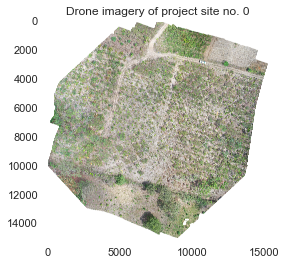

In [18]:
# Load drone imagery 
path_to_drone_raster = os.path.join(path_to_AGBench + '/data/field_data/drone_files/')
drone_raster = rasterio.open(path_to_drone_raster + '{}.tif'.format(site_no))
drone_image, white_pixels = raster_to_image(drone_raster)


plt.title('Drone imagery of project site no. {}'.format(site_no))
plt.grid(False)
plt.imshow(drone_image)
plt.show()
                                 

This is how the site looks like. Beautiful, isn't it? 

## Pre-Processing
Time to make our low resolution (LR) satellite-based map fit the high resolution (HR) overlapping the GPS coordinates of the drone plot. 


The steps are as follows, we:
1. cut the LR satellite map with a padding around the polygon of the site to reduce computation intensity
    - output: **map_crude**
2. linearly interpolate the values for this map and resize the map with the same HR pixel resolution as the drone imagery 
    - output: **map_resized**
3. cut the map further fitting with the GPS locations of the drone imagery 
    - output: **map_fitted**
4. filter out the site area by removing all pixels in the satellite-based map, that are outside of the drone imagery, coloured white 
    - output: **map_filtered**

In [19]:
# Steps 1 to 3
map_crude, map_resized, map_fitted = crop_map_to_site(GFW_satellite_raster, GFW_map_values, 
                                                      drone_raster, drone_image, field_data, site_no)

In [20]:
# Step 4
map_filtered = white_pixels*map_fitted

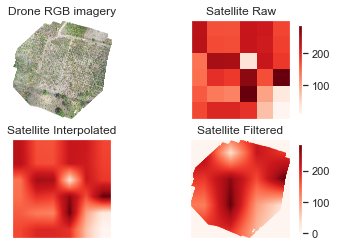

In [21]:
# Visualize the 4 steps
plot_all_sites(drone_image, map_crude, map_resized, map_filtered, site_no)
# Save plot
plt.savefig('{}/data/results/fig_site_{}_combi.png'.format(path_to_AGBench, site_no), dpi=300)

## Analysis
Now, let's get into the analysis. Is the map accurately estimating the amount or density of AGB/carbon? 

In [22]:
# Quick check
compare_mean_AGB_density (field_data, site_no, map_crude, map_fitted, map_filtered)

Mean AGB density:
15.8  : field data (ground truth)
176.1 : map_crude    : x11.2  
168.0 : map_fitted   : x10.7  
175.9 : map_filtered : x11.2  
The satellite-based map over/underestimates by a factor of 11.2


# Just do it - AGBench them all!
Run the full benchmark for all sites for your selected map.

In [23]:
# Insert the map you want to benchmark:

# --- no need to run this if you already did it for the site example above ---

map_name = 'GFW' # Global Forest Watch

# Set path variables
path_to_map_raster = os.path.join(path_to_AGBench + '/data/AGB_maps/00N_080W_t_aboveground_biomass_ha_2000.tif')
path_to_drone_raster = os.path.join(path_to_AGBench + '/data/field_data/drone_files/')

# Load satellite-based map
GFW_satellite_raster = rasterio.open(path_to_map_raster, 'r')
GFW_map_values = GFW_satellite_raster.read(1)

In [24]:
# Run the benchmark for all sites
results = pd.DataFrame(columns=['site no', 'AGB density (field data)'])

print('Ready to benchmark!')

for site_no in range(0, len(field_data)):
    
    # Load drone imagery for the specific site
    drone_raster = rasterio.open(path_to_drone_raster + '{}.tif'.format(site_no))
    drone_image, white_pixels = raster_to_image(drone_raster)
    
    
    # Steps 1 to 3
    print('step 1-3')
    map_crude, map_resized, map_fitted = crop_map_to_site(GFW_satellite_raster, GFW_map_values, 
                                                      drone_raster, drone_image, field_data, site_no)
    
    # Step 4
    print('step 4')
    map_filtered = white_pixels*map_fitted
    
    # Visualize and save an image of the 4 steps
    #plot_all_sites(drone_image, map_crude, map_resized, map_filtered, site_no)
    
    # Compare and store the values
    results = AGB_density_analysis(results, field_data, site_no, map_filtered, map_name)
    
    print('Site no {} is done.'.format(site_no))
    
results.to_csv('{}/data/results/results_{}.csv'.format(path_to_AGBench, map_name))
    

Ready to benchmark!
step 1-3
step 4
Site no 0 is done.
step 1-3
step 4
Site no 1 is done.
step 1-3
step 4
Site no 2 is done.
step 1-3
step 4
Site no 3 is done.
step 1-3
step 4
Site no 4 is done.
step 1-3
step 4
Site no 5 is done.


🎉 The final results 🔥

In [25]:
results 

,site no,AGB density (field data),AGB density (estimation from GFW),Factor for GFW
0,0.0,16.0,176.0,11.2
1,1.0,25.0,160.0,6.4
2,2.0,23.0,47.0,2.0
3,3.0,20.0,62.0,3.1
4,4.0,10.0,19.0,1.8
5,5.0,28.0,141.0,5.1
